In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bagsolver.bag import Bag
from bagsolver.utils import load_bag_data, parse_solution
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
import subprocess

def gen_instances(I, N, n=24, W=3000, C=3000, w="bal", m=0.8, c="uni") -> tuple:
    args = f"-I {I} -N {N} -n {n} -W {W} -C {C} -w {w} -m {m} -c {c}"
    full = f"./data/GEN/kg2 {args}"
    popen = subprocess.Popen(full.split(" "), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, errors = popen.communicate()
    return args, output.decode().strip()

In [130]:
args, instances = gen_instances(1, 10)

In [176]:
import random

def permute_instance(instance):
    iid, count, capacity, *items = instance.split(" ")
    pairs = list(zip(items[::2], items[1::2]))
    random.shuffle(pairs)
    return " ".join([iid, count, capacity] + list(sum(pairs, ())))

In [192]:
# Bound methods of the Bag class
algorithms = ["solve_bruteforce", "solve_branch_bound", "solve_greedy", "solve_dynamic_cost"]

### Generate robust

In [249]:
iid = 1  # starting instance id
N = 500  # number of generated items
n = 20   # instance size

records = []

# weight distribution - default bal
args, result = gen_instances(iid, N, n=n)
for inst in result.split("\n"):
    for alg in algorithms:
        for i in range(10):
            perminst = permute_instance(inst)
            records.append([perminst, alg, args])

tasks = pd.DataFrame(records, columns=["instance", "method", "args"])
tasks.to_csv("hw3_tasks_robust.csv", index=False)

In [215]:
df = pd.read_csv("hw3_output_robust.csv")

In [217]:
df["id"] = df.instance.apply(lambda x: x.split(" ")[0])

In [226]:
var = df.groupby(by=["method", "id"]).elapsed.agg(["var"])

In [237]:
mean_var = var.reset_index().groupby("method")["var"].mean()

In [247]:
pd.options.display.float_format = '{:.8f}'.format

In [248]:
print(mean_var.to_latex())

\begin{tabular}{lr}
\toprule
{} &        var \\
method             &            \\
\midrule
solve\_branch\_bound & 0.00016046 \\
solve\_bruteforce   & 0.00017201 \\
solve\_dynamic\_cost & 0.06896283 \\
solve\_greedy       & 0.00000004 \\
\bottomrule
\end{tabular}



### Generate pilot

In [250]:
iid = 1  # starting instance id
N = 10   # number of generated items
n = 20   # instance size

records = []

# weight distribution - default bal
for w in ["bal", "light", "heavy"]:
    # the ratio of max knapsack capacity to total weight
    for m in np.linspace(0, 2, 5):
        # cost distribution/style - default uni
        for c in ["uni", "corr", "strong"]:
            args, result = gen_instances(iid, N, n=n, w=w, m=m, c=c)
            for inst in result.split("\n"):
                for alg in algorithms:
                    records.append([inst, alg, args])
            iid += N

tasks = pd.DataFrame(records, columns=["instance", "method", "args"])
tasks.to_csv("hw3_tasks_pilot.csv", index=False)

### Prepare data for pilot

In [17]:
def args2dict(args) -> dict:
    return {tup.split(" ")[0]: tup.split(" ")[1] for tup in args.strip("-").split("-")}

In [115]:
df = pd.read_csv("hw3_output_pilot.csv")
df.args = df.args.apply(args2dict)
df = df.join(pd.json_normalize(df.args)).drop(columns=["args"])

In [116]:
df.m = df.m.astype(float)

In [117]:
def plot_corr(method):
    sub = df[df.method==method]
    fact = sub[["w", "m", "c"]].apply(lambda x: pd.factorize(x)[0])
    fact["elapsed"] = sub.elapsed
    corr = fact.corr(method="pearson", min_periods=1)
    return corr["elapsed"]

In [118]:
results = []
for method in df.method.unique():
    c = plot_corr(method)
    results.append([method, c["w"], c["m"], c["c"]])

In [119]:
res = pd.DataFrame(results, columns=["method", "w", "m", "c"])
corr = res.set_index("method").abs()

In [127]:
corr = corr.rename(
    columns={
        "w": "w_dist",   # weight distribution
        "m": "cw_ratio", # ratio of max knapsack capacity to total weight
        "c": "pw_corr",  # cost distribution/style - default uni
    }
)

<AxesSubplot:ylabel='method'>

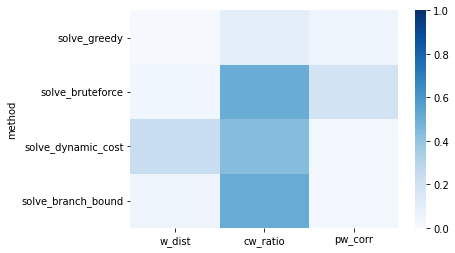

In [128]:
sns.heatmap(corr, vmin=0, vmax=1, cmap="Blues")